In [1]:
import numpy as np
import pandas as pd
import tifffile as tf
from cellpose import models
from cellpose import utils
from skimage.measure import label, regionprops
import os
from tqdm import tqdm
from scipy.spatial.distance import cdist
from skimage.segmentation import expand_labels, watershed
import matplotlib.pyplot as plt

In [2]:
import scanpy as sc

In [3]:
import tifffile as tiff
img_path = "ShamR-output-XETG00063__0005295__Region_6__20230717__191520/morphology.ome.tif"
img = tiff.imread(img_path)
dapi = img[5]

In [4]:
read_positions = pd.read_csv("Baysor_out/ShamR_filtered_transcripts.csv")
x1, y1, x2, y2 = 2300/0.2125, 650/0.2125, 2400/0.2125, 750/0.2125
print(x1, x2, y1, y2)

10823.529411764706 11294.117647058823 3058.823529411765 3529.4117647058824


In [5]:
all_transcript_subset = read_positions.query('x_location>@x1 and x_location<@x2 and y_location>@y1 and y_location<@y2')

In [6]:
croped = dapi[3058:3529,10823:11294]

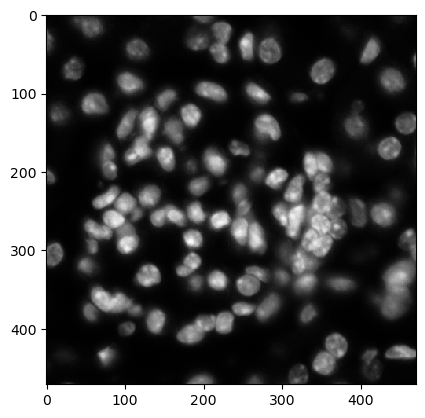

In [7]:
fig, ax = plt.subplots(dpi=100)
ax.imshow(croped, cmap = "Greys_r", interpolation="none")
ax.axis('scaled')
ax.grid(False)
plt.show()

## Cellpose

In [8]:
model_cp = models.Cellpose(gpu=False, model_type='nuclei')
print('starting segmentation...')
masks, flows, styles, diams = model_cp.eval(croped, diameter=None, channels=[0, 0])
# Label the segmented nuclei
labeled_nuclei = label(masks)

/home/qiao/anaconda3/envs/stardist-env/lib/python3.11/site-packages/cellpose/resnet_torch.py:280: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filen

starting segmentation...


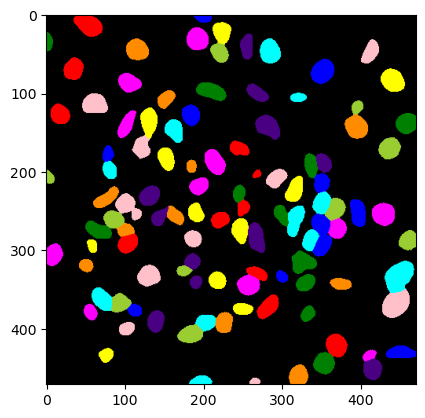

In [9]:
# Label the segmented nuclei
labeled_nuclei = label(masks)
expanded_nuclei = expand_labels(labeled_nuclei, distance=400)
from skimage.color import label2rgb
color1 = label2rgb(labeled_nuclei, bg_label=0)
plt.imshow(color1)

## StarDist

In [ ]:
# Import the StarDist 2D segmentation models.
# Import the recommended normalization technique for stardist.
from csbdeep.utils import normalize
from stardist.models import StarDist2D
import matplotlib.pyplot as plt

In [ ]:
from csbdeep.utils import normalize

croped_norm = normalize(croped, 1, 99.8, axis=(0, 1))
model_stardist = StarDist2D.from_pretrained('2D_versatile_fluo')
labels_stardist, _ = model_stardist.predict_instances(croped_norm)

labeled_nuclei_stardist = label(labels_stardist)


In [ ]:
# Visualize segmented nuclei
color_stardist = label2rgb(labeled_nuclei_stardist, bg_label=0)
fig, ax = plt.subplots(dpi=100)
ax.imshow(color_stardist)
ax.axis('scaled')
ax.axis("off")
ax.grid(False)
plt.show()

## DeepCell

In [ ]:
from deepcell.applications import NuclearSegmentation

In [ ]:
import os
app = NuclearSegmentation.from_version("1.1")

In [ ]:
# Convert the 2D array to a 4D array (1, height, width, 1)
dapi_image_4d = np.expand_dims(np.expand_dims(croped, axis=0), axis=-1)
masks_deepcell = app.predict(dapi_image_4d)
masks_deepcell = np.squeeze(masks_deepcell)
# Label the segmented nuclei
labeled_nuclei_deepcell = label(masks_deepcell) 

In [ ]:
# Label the segmented nuclei
labeled_nuclei_deepcell = label(masks_deepcell) 

# Visualize segmented nuclei
color_deepcell = label2rgb(labeled_nuclei_deepcell, bg_label=0)
plt.imshow(color_deepcell)
plt.show()

## Map the transcripts to segmented cells

In [ ]:
all_transcript_subset['x_new'] = all_transcript_subset['x_location'] - 10823.529411764706
all_transcript_subset['y_new'] = all_transcript_subset['y_location'] - 3058.823529411765

centroid_dictx_stardist = {}
centroid_dicty_stardist = {}
for nucleus_props in regionprops(labeled_nuclei_stardist):
    centroid_dictx_stardist[nucleus_props.label] = nucleus_props.centroid[1]  # x
    centroid_dicty_stardist[nucleus_props.label] = nucleus_props.centroid[0]  # y

in_cell=[]
for ind in tqdm(all_transcript_subset.index):
    try:
        in_cell.append(labeled_nuclei_stardist[int(all_transcript_subset.loc[ind,'y_new']),int(all_transcript_subset.loc[ind,'x_new'])])
    except:
        in_cell.append(0)
        
all_transcript_subset['in_cell']=in_cell
all_transcript_subset['distance_to_centroid']=np.sqrt((all_transcript_subset['closest_cell_y']-all_transcript_subset['y_new'])**2 +(all_transcript_subset['closest_cell_x']-all_transcript_subset['x_new'])**2)

In [ ]:
import random

all_transcript_subset_sd = all_transcript_subset[all_transcript_subset.in_cell !=0]

cells = np.unique(all_transcript_subset_sd.in_cell)
tx_col = ["#" + ''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                          for i in range(len(cells))]
map_dict = {cells[i]: tx_col[i] for i in range(len(cells))}

all_tx = all_transcript_subset_sd['in_cell'].to_list()
all_tx = pd.DataFrame(all_tx, columns=['colors'])
all_tx = all_tx.replace({'colors': map_dict})

In [ ]:
fig, ax = plt.subplots(dpi=100)
ax.imshow(croped, cmap = "Greys_r", interpolation="none")
ax.scatter(all_transcript_subset_sd.x_new, all_transcript_subset_sd.y_new, facecolors=all_tx.colors, edgecolors='none', s=8, alpha=1)
ax.axis('scaled')
ax.grid(False)
ax.set_xlim(0, 471)
ax.set_ylim(0, 471)
ax.invert_yaxis()
plt.show()

In [20]:
all_transcript_subset_nuclei = all_transcript_subset[all_transcript_subset.overlaps_nucleus == 1]

In [21]:
import random
cells = np.unique(all_transcript_subset_nuclei.cell_id)
tx_col = ["#" + ''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                          for i in range(len(cells))]
map_dict = {cells[i]: tx_col[i] for i in range(len(cells))}

all_tx = all_transcript_subset_nuclei['cell_id'].to_list()
all_tx = pd.DataFrame(all_tx, columns=['colors'])
all_tx = all_tx.replace({'colors': map_dict})

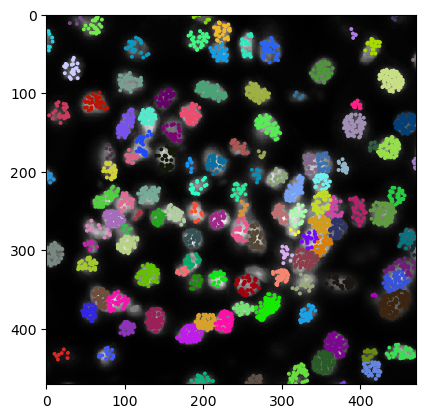

In [22]:
fig, ax = plt.subplots(dpi=100)
ax.imshow(croped, cmap = "Greys_r", interpolation="none")
ax.scatter(all_transcript_subset_nuclei.x_new, all_transcript_subset_nuclei.y_new, facecolors=all_tx.colors, edgecolors='none', s=8, alpha=1)
ax.axis('scaled')
ax.grid(False)
ax.set_xlim(0, 471)
ax.set_ylim(0, 471)
ax.invert_yaxis()
plt.show()

In [23]:
all_transcript_subset_cp = all_transcript_subset[all_transcript_subset.in_cell !=0]

cells = np.unique(all_transcript_subset_cp.in_cell)
tx_col = ["#" + ''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                          for i in range(len(cells))]
map_dict = {cells[i]: tx_col[i] for i in range(len(cells))}

all_tx = all_transcript_subset_cp['in_cell'].to_list()
all_tx = pd.DataFrame(all_tx, columns=['colors'])
all_tx = all_tx.replace({'colors': map_dict})

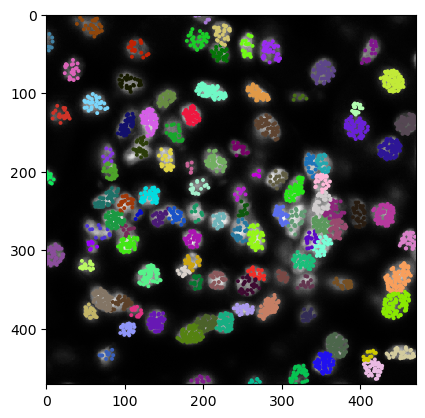

In [24]:
fig, ax = plt.subplots(dpi=100)
ax.imshow(croped, cmap = "Greys_r", interpolation="none")
ax.scatter(all_transcript_subset_cp.x_new, all_transcript_subset_cp.y_new, facecolors=all_tx.colors, edgecolors='none', s=8, alpha=1)
ax.axis('scaled')
ax.grid(False)
ax.set_xlim(0, 471)
ax.set_ylim(0, 471)
ax.invert_yaxis()
plt.show()

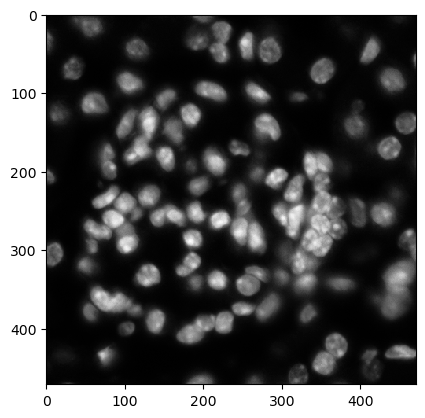

In [25]:
fig, ax = plt.subplots(dpi=100)
ax.imshow(croped, cmap = "Greys_r", interpolation="none")
ax.axis('scaled')
ax.grid(False)
ax.set_xlim(0, 471)
ax.set_ylim(0, 471)
ax.invert_yaxis()
plt.show()

In [30]:
all_transcript_subset_cp.to_csv('Seg_result/transcripts_Cellpose.csv')
adata.write_h5ad('Seg_result/adata_Cellpose.h5ad')

In [66]:
all_transcript_subset_nuclei.to_csv('Seg_result/transcripts_XeniumNuclei.csv')

In [65]:
all_transcript_subset_nuclei = all_transcript_subset[all_transcript_subset.overlaps_nucleus!=0]

In [151]:
df = pd.read_csv('Seg_result/transcripts_XeniumNuclei.csv', index_col=0)

In [153]:
cellxgene=pd.crosstab(df['cell_id'],df['feature_name'])
cellxgene=cellxgene.loc[~cellxgene.index.isin([0]),:]
import scanpy as sc
adata=sc.AnnData(cellxgene)
adata.obs[['x_centroid','y_centroid']]=df[['x_new','y_new']]
adata

AnnData object with n_obs × n_vars = 126 × 239
    obs: 'x_centroid', 'y_centroid'

In [154]:
adata.write_h5ad('Seg_result/adata_XeniumNuclei.h5ad')

In [6]:
#df = pd.read_csv('transcripts_XeniumCell.csv')

In [52]:
all_transcript_subset.to_csv('Seg_result/transcripts_XeniumCell.csv')

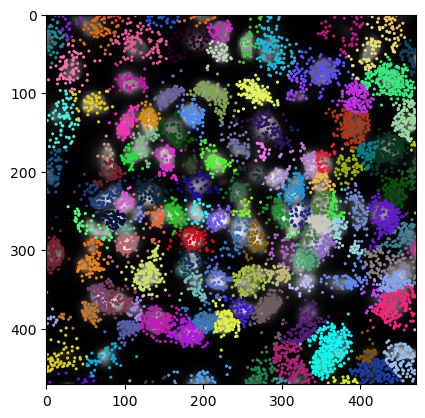

In [49]:
cells = np.unique(all_transcript_subset.cell_id)
tx_col = ["#" + ''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                          for i in range(len(cells))]
map_dict = {cells[i]: tx_col[i] for i in range(len(cells))}

all_tx = all_transcript_subset['cell_id'].to_list()
all_tx = pd.DataFrame(all_tx, columns=['colors'])
all_tx = all_tx.replace({'colors': map_dict})

fig, ax = plt.subplots(dpi=100)
ax.imshow(croped, cmap = "Greys_r", interpolation="none")
ax.scatter(all_transcript_subset.x_new, all_transcript_subset.y_new, facecolors=all_tx.colors, edgecolors='none', s=5, alpha=1)
ax.axis('scaled')
ax.grid(False)
ax.set_xlim(0, 471)
ax.set_ylim(0, 471)
ax.invert_yaxis()
plt.show()

#### Compare

In [16]:
methods = ['XeniumCell', 'XeniumNuclei', 'Cellpose', 'StarDist', 'Deepcell','Baysor']
csv_files = [f'transcripts_{method}.csv' for method in methods]

# Dictionary to store the number of transcripts for each method
transcript_counts = {}

for i, (method, csv_file) in enumerate(zip(methods, csv_files)):
    # Load the transcript CSV file
    transcripts_df = pd.read_csv(csv_file, index_col=0)
    # Store the total number of transcripts retrieved after segmentation
    transcript_counts[method] = len(transcripts_df)

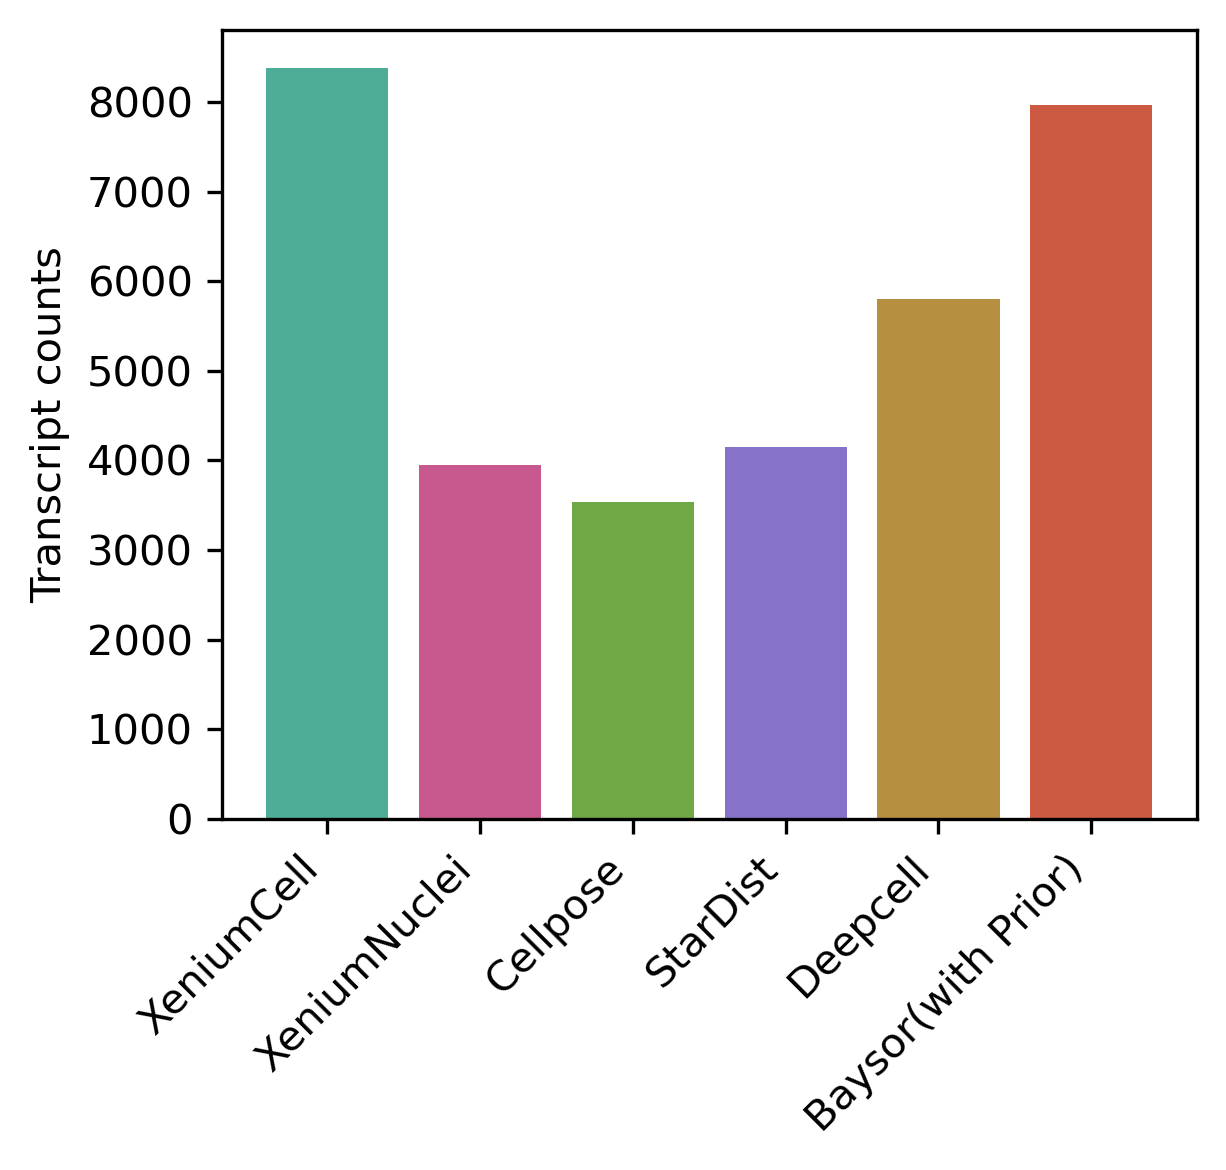

In [17]:
fig, ax = plt.subplots(figsize = (4,4), dpi=300)
plt.bar(transcript_counts.keys(), transcript_counts.values(), color = ["#4dad97","#c8598f","#70a845","#8772c9","#b68f40","#cc5a43"])
new_labels = ['XeniumCell', 'XeniumNuclei', 'Cellpose', 'StarDist', 'Deepcell', 'Baysor(with Prior)']  # Replace 'Method6' if applicable
ax.set_xticks(np.arange(len(transcript_counts.keys())))  # Set tick positions
ax.set_xticklabels(new_labels, rotation=45, ha='right')  # Apply new labels
plt.tight_layout()
plt.ylabel("Transcript counts")
plt.savefig("compare_seg.png", transparent = True, bbox_inches = "tight")
plt.show()

Cellpose


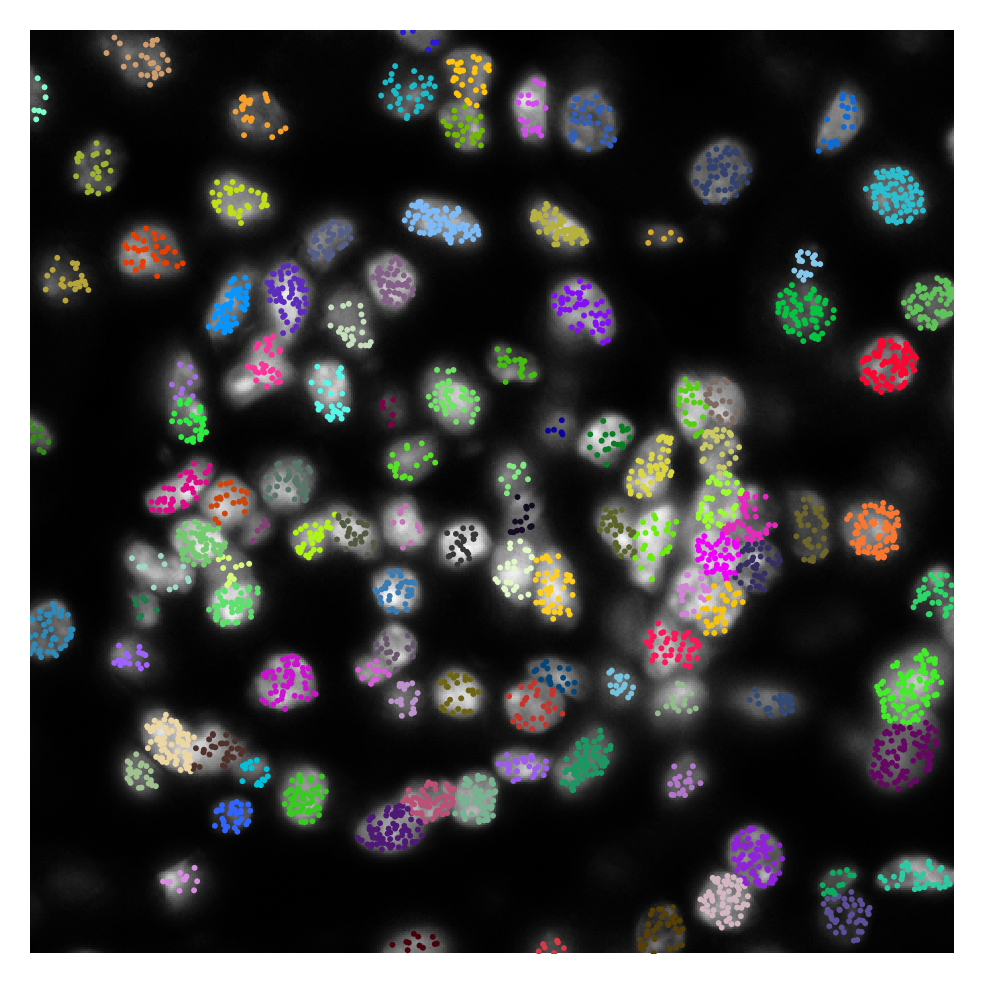

StarDist


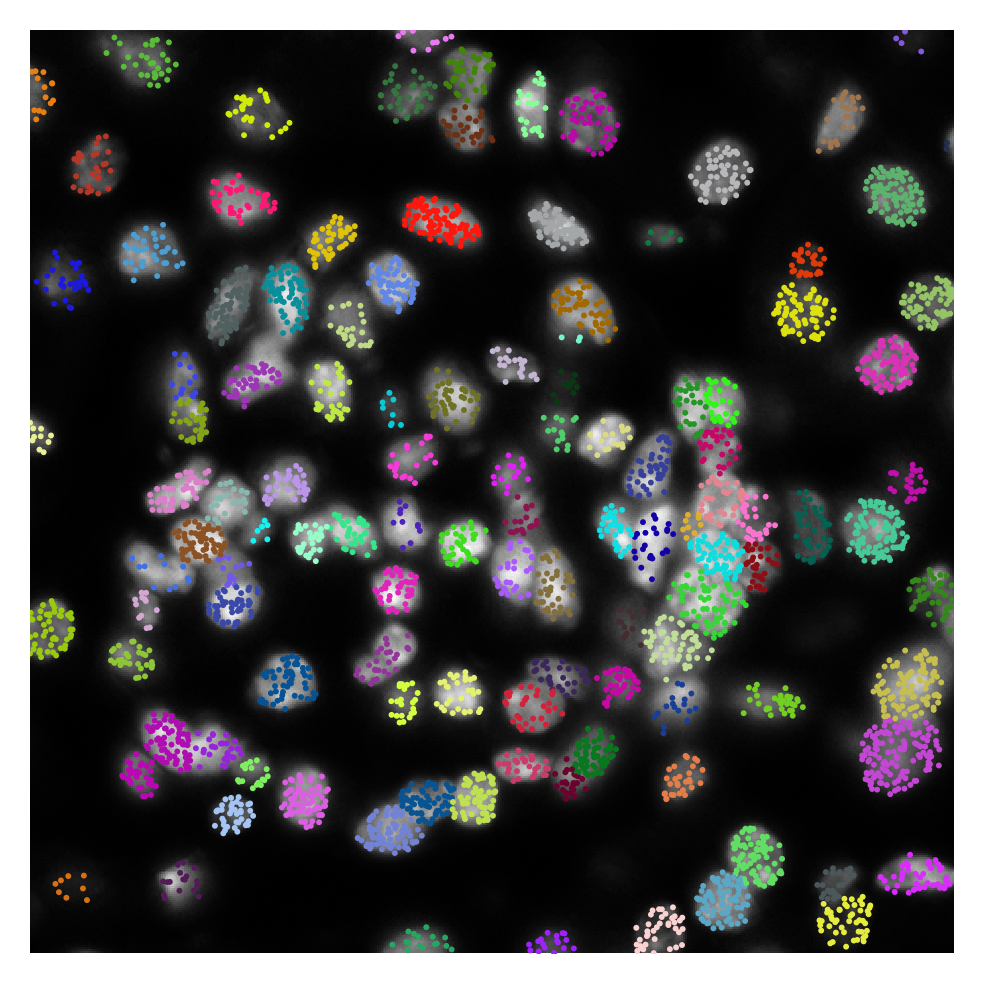

Deepcell


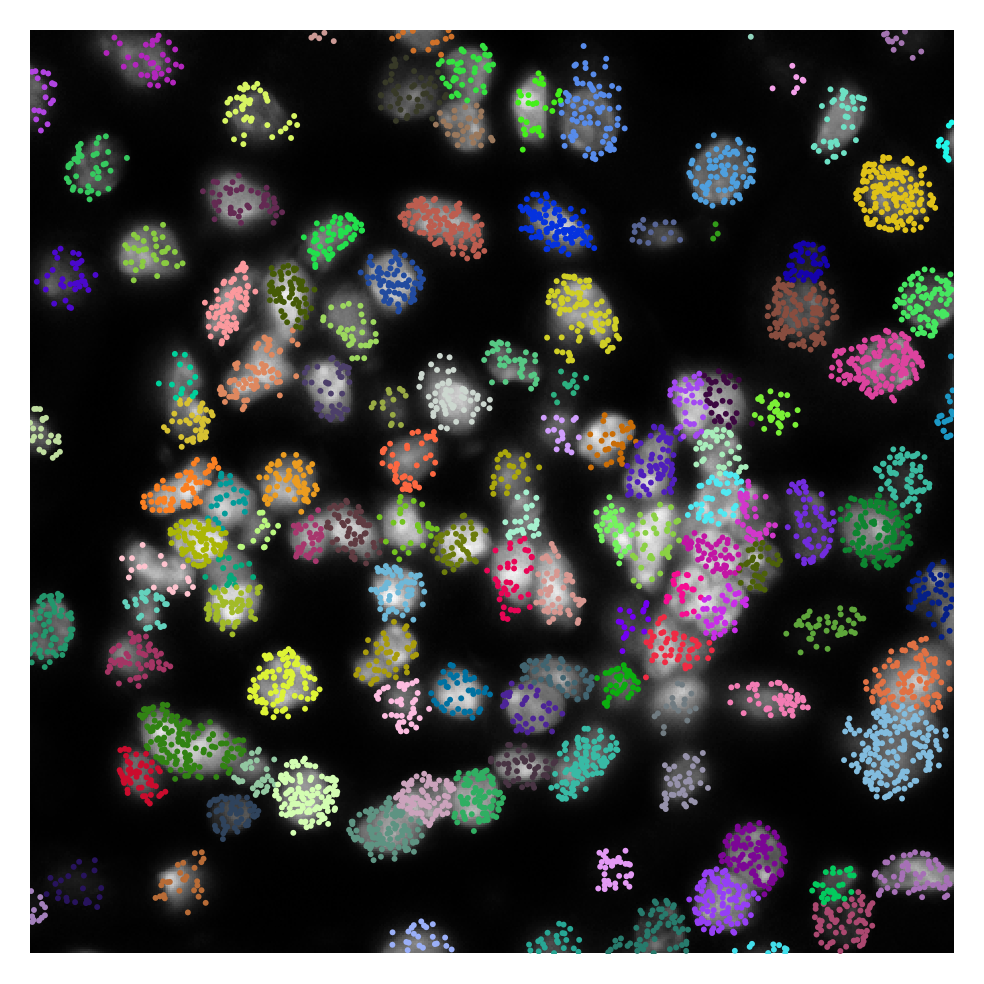

Baysor


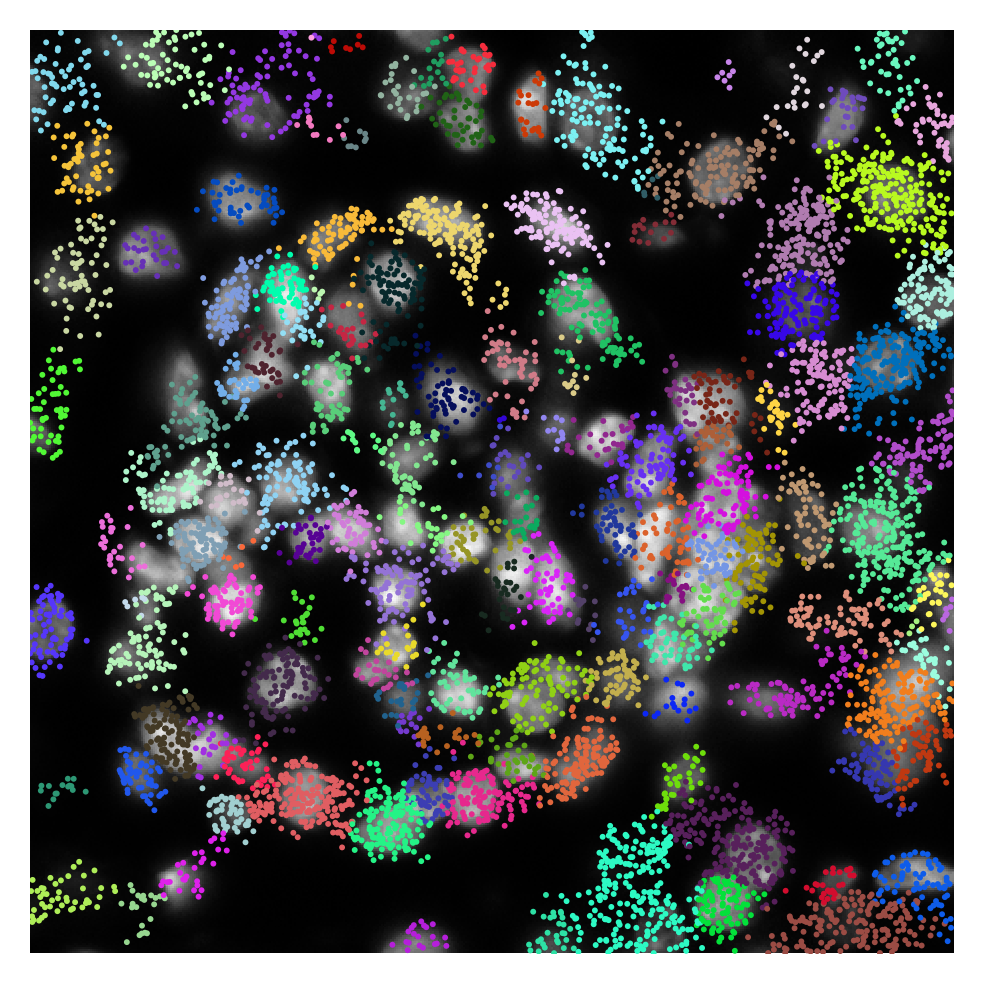

In [146]:
methods = ['Cellpose', 'StarDist', 'Deepcell','Baysor']
csv_files = [f'Seg_result/transcripts_{method}.csv' for method in methods]

for i, (method, csv_file) in enumerate(zip(methods, csv_files)):
    print(method)
    transcripts_df = pd.read_csv(csv_file, index_col=0)

    cells = np.unique(transcripts_df['in_cell'])
    tx_col = ["#" + ''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                              for i in range(len(cells))]
    map_dict = {cells[i]: tx_col[i] for i in range(len(cells))}
    
    all_tx = transcripts_df['in_cell'].to_list()
    all_tx = pd.DataFrame(all_tx, columns=['colors'])
    all_tx = all_tx.replace({'colors': map_dict})
    
    fig, ax = plt.subplots(figsize = (4,4), dpi=300)
    ax.imshow(croped, cmap = "Greys_r", interpolation="none")
    ax.scatter(transcripts_df.x_new, transcripts_df.y_new, facecolors=all_tx.colors, edgecolors='none', s=2, alpha=1)
    ax.axis('scaled')
    ax.grid(False)
    ax.set_xlim(0, 471)
    ax.set_ylim(0, 471)
    ax.invert_yaxis()
    ax.axis("off")
    plt.savefig(f"{method}_seg_dapi.png", transparent = True, bbox_inches = "tight")
    plt.show()

In [208]:
import random
import matplotlib.font_manager as fm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

df = pd.read_csv('transcripts_XeniumCell.csv', index_col=0)
df['x_new'] = df['x_location'] - 10823.529411764706
df['y_new'] = df['y_location'] - 3058.823529411765

cells = np.unique(df.cell_id)
tx_col = ["#" + ''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                          for i in range(len(cells))]
map_dict = {cells[i]: tx_col[i] for i in range(len(cells))}
#map_dict[0] = '#DCDCDC'

df['color'] = df['cell_id'].map(map_dict)
#df.loc[df['overlaps_nucleus'] == 0, 'color'] = '#DCDCDC'  # Grey for non-overlapping transcripts

fig, ax = plt.subplots(figsize = (4,4),dpi=300)
ax.imshow(croped, cmap = "Greys_r", interpolation="none")
ax.scatter(df.x_new, df.y_new, facecolors=df['color'], edgecolors='none', s=2, alpha=1)
ax.axis('scaled')
ax.grid(False)
scalebar = AnchoredSizeBar(
            ax.transData,
            94.11764705882354,
            " ",
            "lower left",
            pad=0.1,
            sep=-5,
            color="white",
            frameon=False,
            size_vertical=4,
            fontproperties=fm.FontProperties(size=12),
        )
ax.add_artist(scalebar)
ax.set_xlim(0, 471)
ax.set_ylim(0, 471)
ax.invert_yaxis()
ax.axis("off")
plt.savefig(f"XeniumCell_seg_dapi.png", transparent = True, bbox_inches = "tight")
plt.show()

94.11764705882354

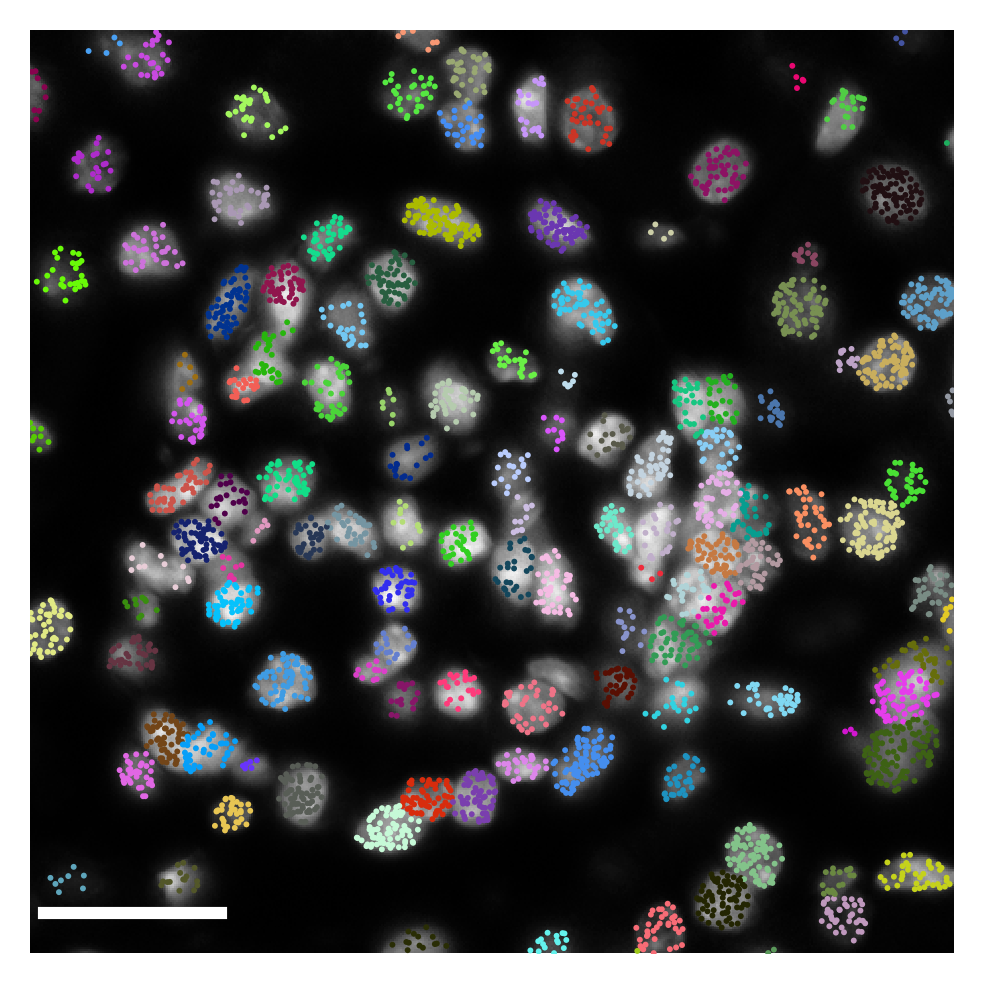

In [26]:
import random
import matplotlib.font_manager as fm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

df = pd.read_csv('transcripts_XeniumNuclei.csv', index_col=0)
df['x_new'] = df['x_location'] - 10823.529411764706
df['y_new'] = df['y_location'] - 3058.823529411765

cells = np.unique(df.cell_id)
tx_col = ["#" + ''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                          for i in range(len(cells))]
map_dict = {cells[i]: tx_col[i] for i in range(len(cells))}
#map_dict[0] = '#DCDCDC'

df['color'] = df['cell_id'].map(map_dict)
df.loc[df['overlaps_nucleus'] == 0, 'color'] = '#DCDCDC'  # Grey for non-overlapping transcripts

fig, ax = plt.subplots(figsize = (4,4),dpi=300)
ax.imshow(croped, cmap = "Greys_r", interpolation="none")
ax.scatter(df.x_new, df.y_new, facecolors=df['color'], edgecolors='none', s=2, alpha=1)
ax.axis('scaled')
ax.grid(False)
scalebar = AnchoredSizeBar(
            ax.transData,
            94.11764705882354,
            " ",
            "lower left",
            pad=0.1,
            sep=-5,
            color="white",
            frameon=False,
            size_vertical=4,
            fontproperties=fm.FontProperties(size=12),
        )
ax.add_artist(scalebar)
ax.set_xlim(0, 471)
ax.set_ylim(0, 471)
ax.invert_yaxis()
ax.axis("off")
plt.savefig(f"Xenium_Nuclei_seg_dapi.png", transparent = True, bbox_inches = "tight")
plt.show()

In [26]:
methods = ['XeniumAll',  'Cellpose', 'StarDist', 'Deepcell','Baysor']
ad_files = [f'adata_{method}.h5ad' for method in methods]
adata_dict = {}
cell_count = {}
for i, (method, ad_file) in enumerate(zip(methods, ad_files)):
    print(method)
    adata = sc.read_h5ad(ad_file)
    adata.layers['raw']=adata.X.copy()
    sc.pp.filter_cells(adata,min_counts=10)
    sc.pp.filter_cells(adata,min_genes=3)
    adata.raw=adata
    adata.layers['raw']=adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=100)
    sc.pp.log1p(adata)
    sc.tl.pca(adata, svd_solver='arpack')

    sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
    sc.tl.leiden(adata,resolution=1)
    sc.tl.umap(adata)
    adata_dict[method] = adata
    cell_count[method] = adata.shape[0]
    

XeniumAll
Cellpose
StarDist
Deepcell
Baysor


/tmp/ipykernel_2481405/2866561396.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45, ha='right')  # Apply new labels


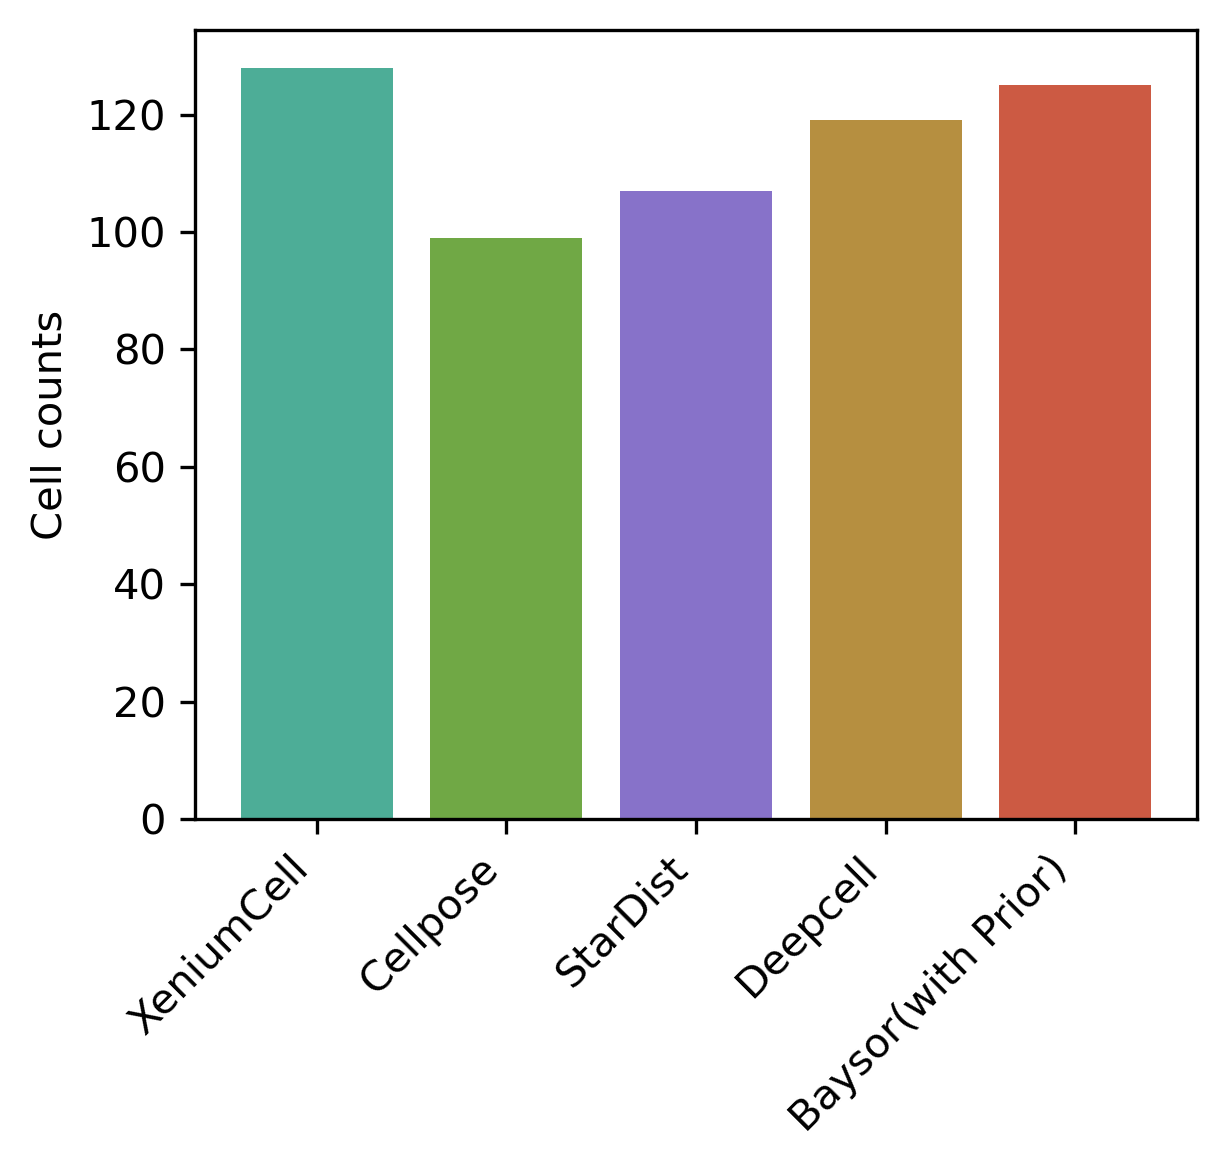

In [31]:
fig, ax = plt.subplots(figsize = (4,4), dpi=300)
plt.bar(cell_count.keys(), cell_count.values(), color = ["#4dad97","#70a845","#8772c9","#b68f40","#cc5a43"])
new_labels = ['XeniumCell', 'Cellpose', 'StarDist', 'Deepcell', 'Baysor(with Prior)']  # Replace 'Method6' if applicable
#ax.set_xticks(np.arange(len(transcript_counts.keys())))  # Set tick positions
ax.set_xticklabels(new_labels, rotation=45, ha='right')  # Apply new labels
plt.tight_layout()
plt.ylabel("Cell counts")
plt.savefig("compare_cell.png", transparent = True, bbox_inches = "tight")
plt.show()

In [ ]:
adata_dict

In [8]:
XeniumCell = adata_dict['XeniumAll']
XeniumCell = XeniumCell[XeniumCell.obs.index.isin(df['cell_id'].unique())]

In [9]:
XeniumCell.X = XeniumCell.raw.X

/home/qiao/anaconda3/envs/scvi-env/lib/python3.10/site-packages/anndata/_core/anndata.py:618: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)


In [10]:
adata_dict['XeniumAll'] = XeniumCell

In [22]:
sc.pp.normalize_total(XeniumCell, target_sum=100)
sc.pp.log1p(XeniumCell)
sc.tl.pca(XeniumCell, svd_solver='arpack')

sc.pp.neighbors(XeniumCell, n_neighbors=15, n_pcs=30)
sc.tl.leiden(XeniumCell,resolution=1)
sc.tl.umap(XeniumCell)

/home/qiao/anaconda3/envs/commot/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


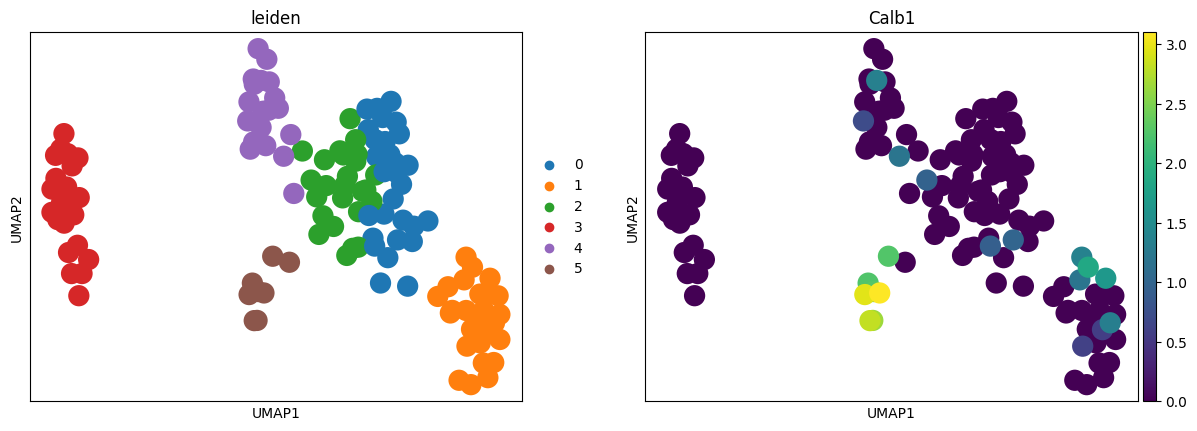

In [31]:
sc.pl.umap(XeniumCell, color=['leiden', 'Calb1'], ncols=8, use_raw=False)

XeniumAll


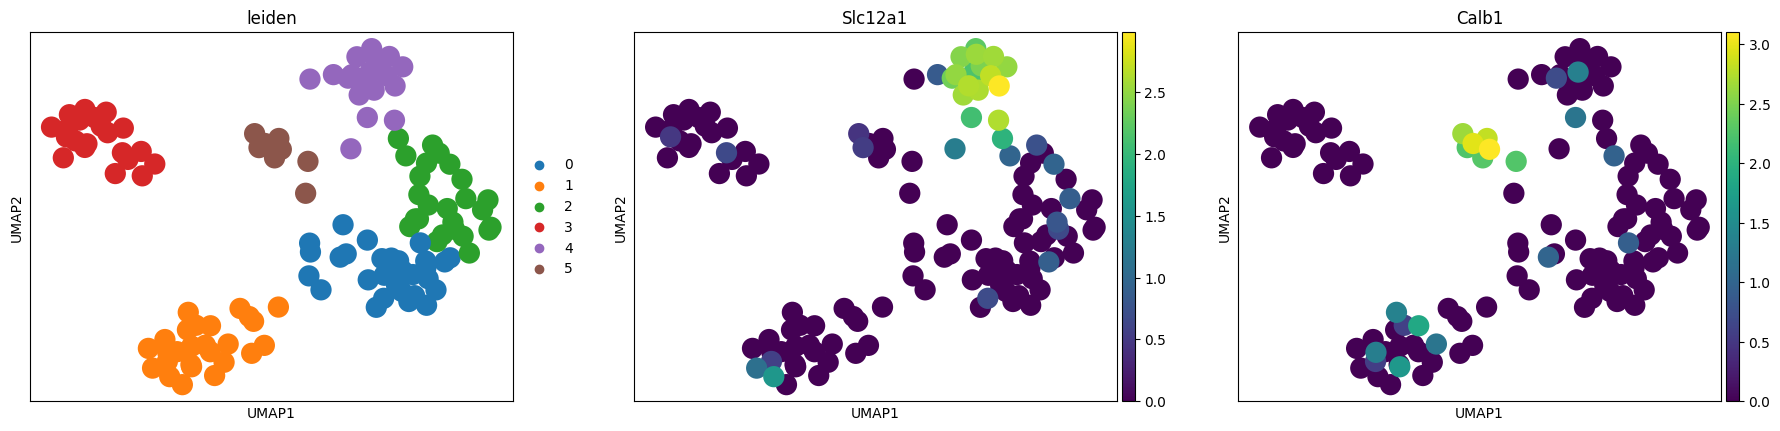

XeniumNuclei


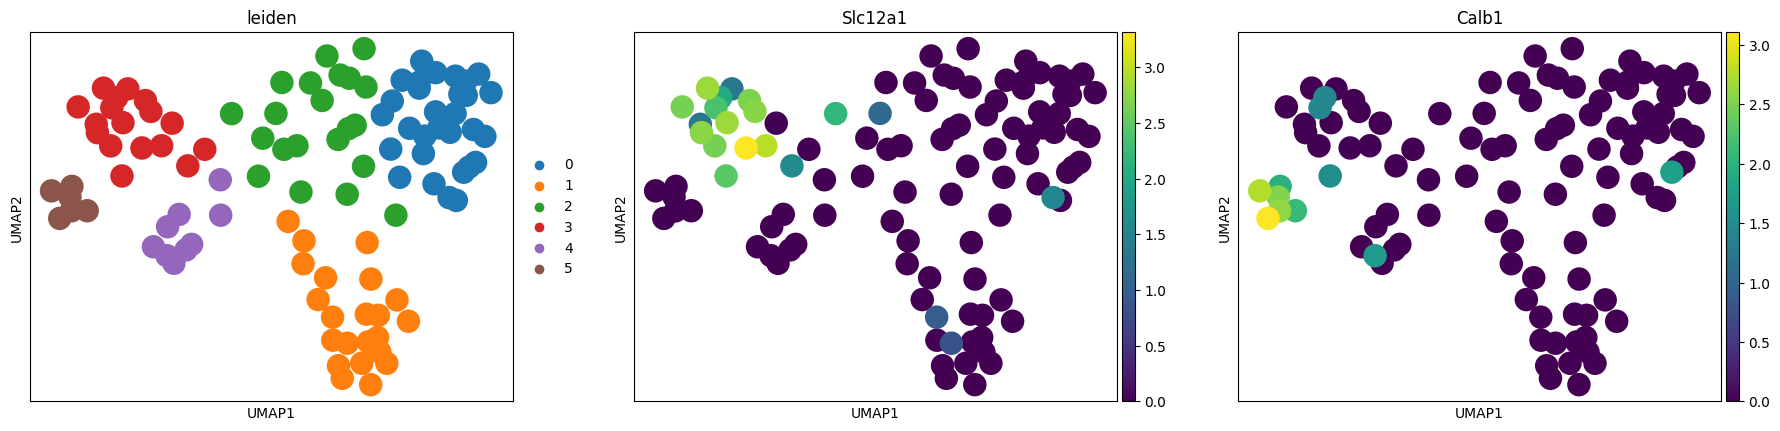

Cellpose


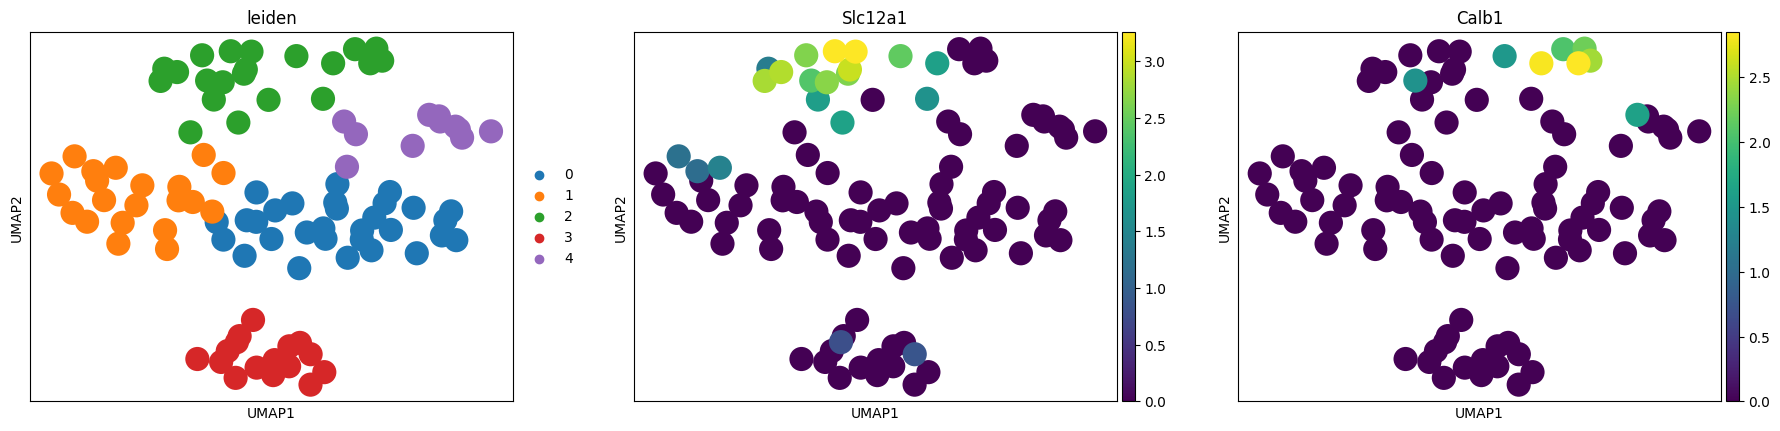

StarDist


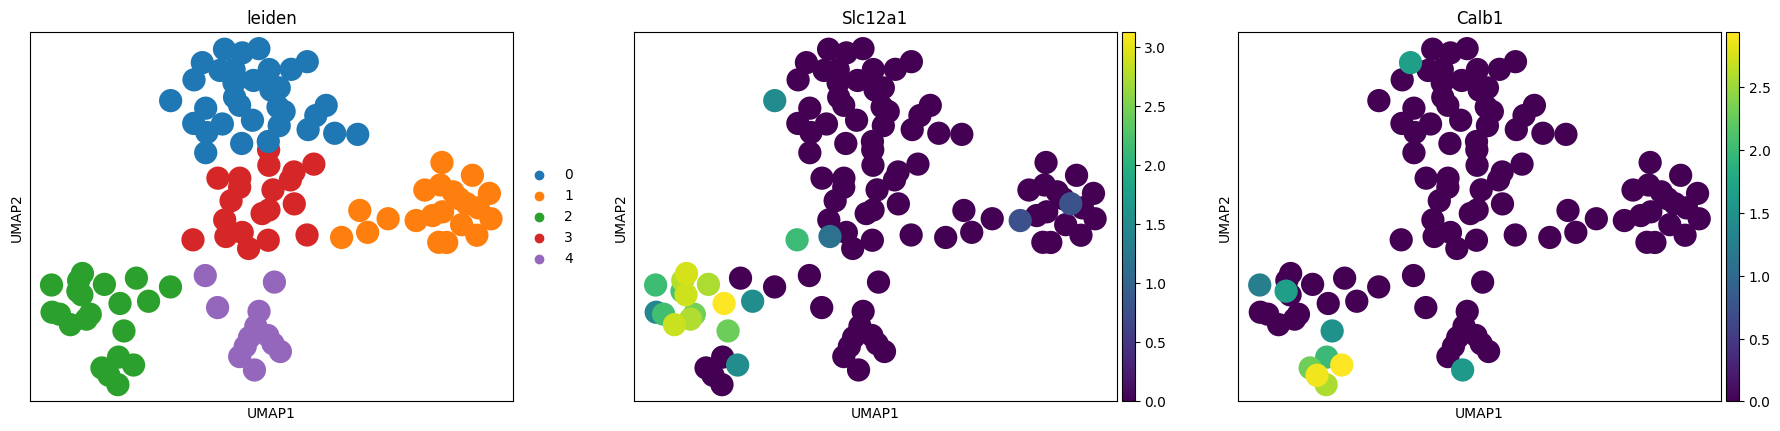

Deepcell


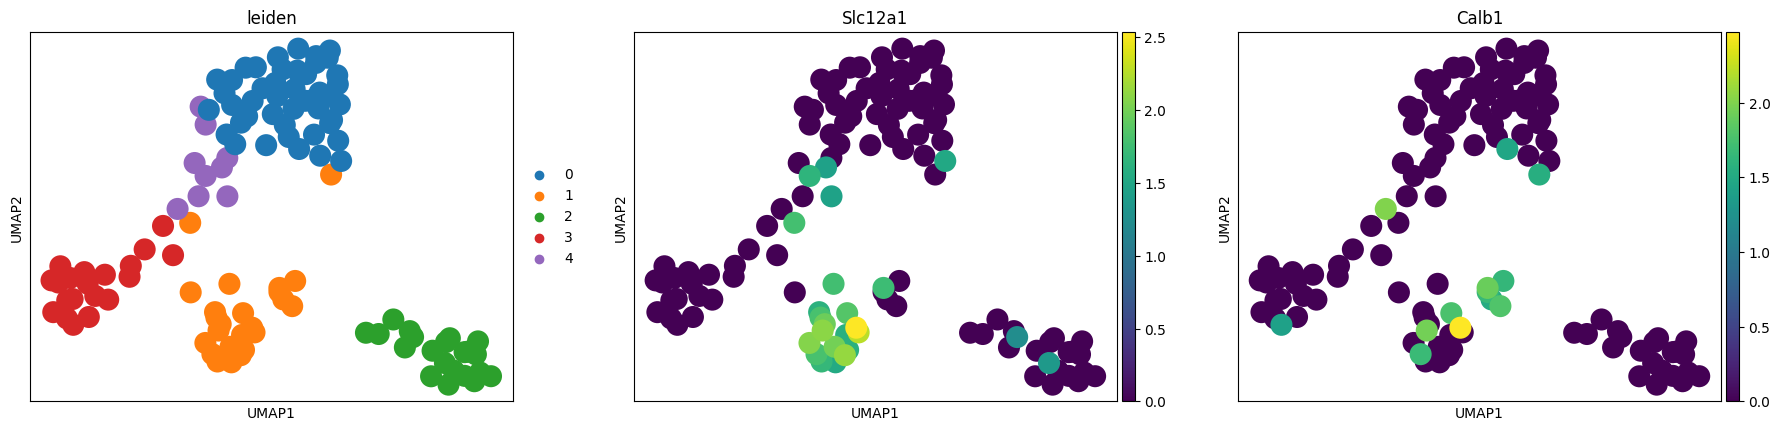

Baysor


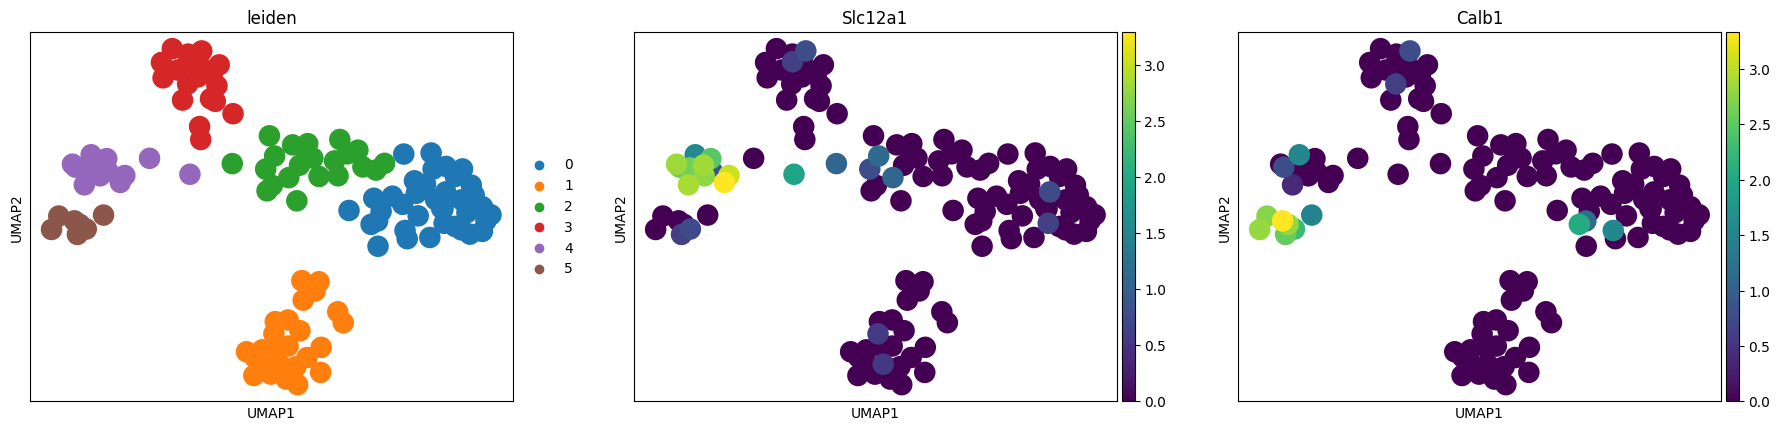

In [14]:
for i, method in enumerate(methods):
    print(method)
    adata_dict[method].X = adata_dict[method].raw.X
    sc.pp.normalize_total(adata_dict[method], target_sum=100)
    sc.pp.log1p(adata_dict[method])
    sc.tl.pca(adata_dict[method], svd_solver='arpack')
    
    sc.pp.neighbors(adata_dict[method], n_neighbors=15, n_pcs=30)
    sc.tl.leiden(adata_dict[method],resolution=1)
    sc.pl.umap(adata_dict[method], color=['leiden', 'Slc12a1','Calb1'], ncols=8, use_raw=False)

XeniumNuclei


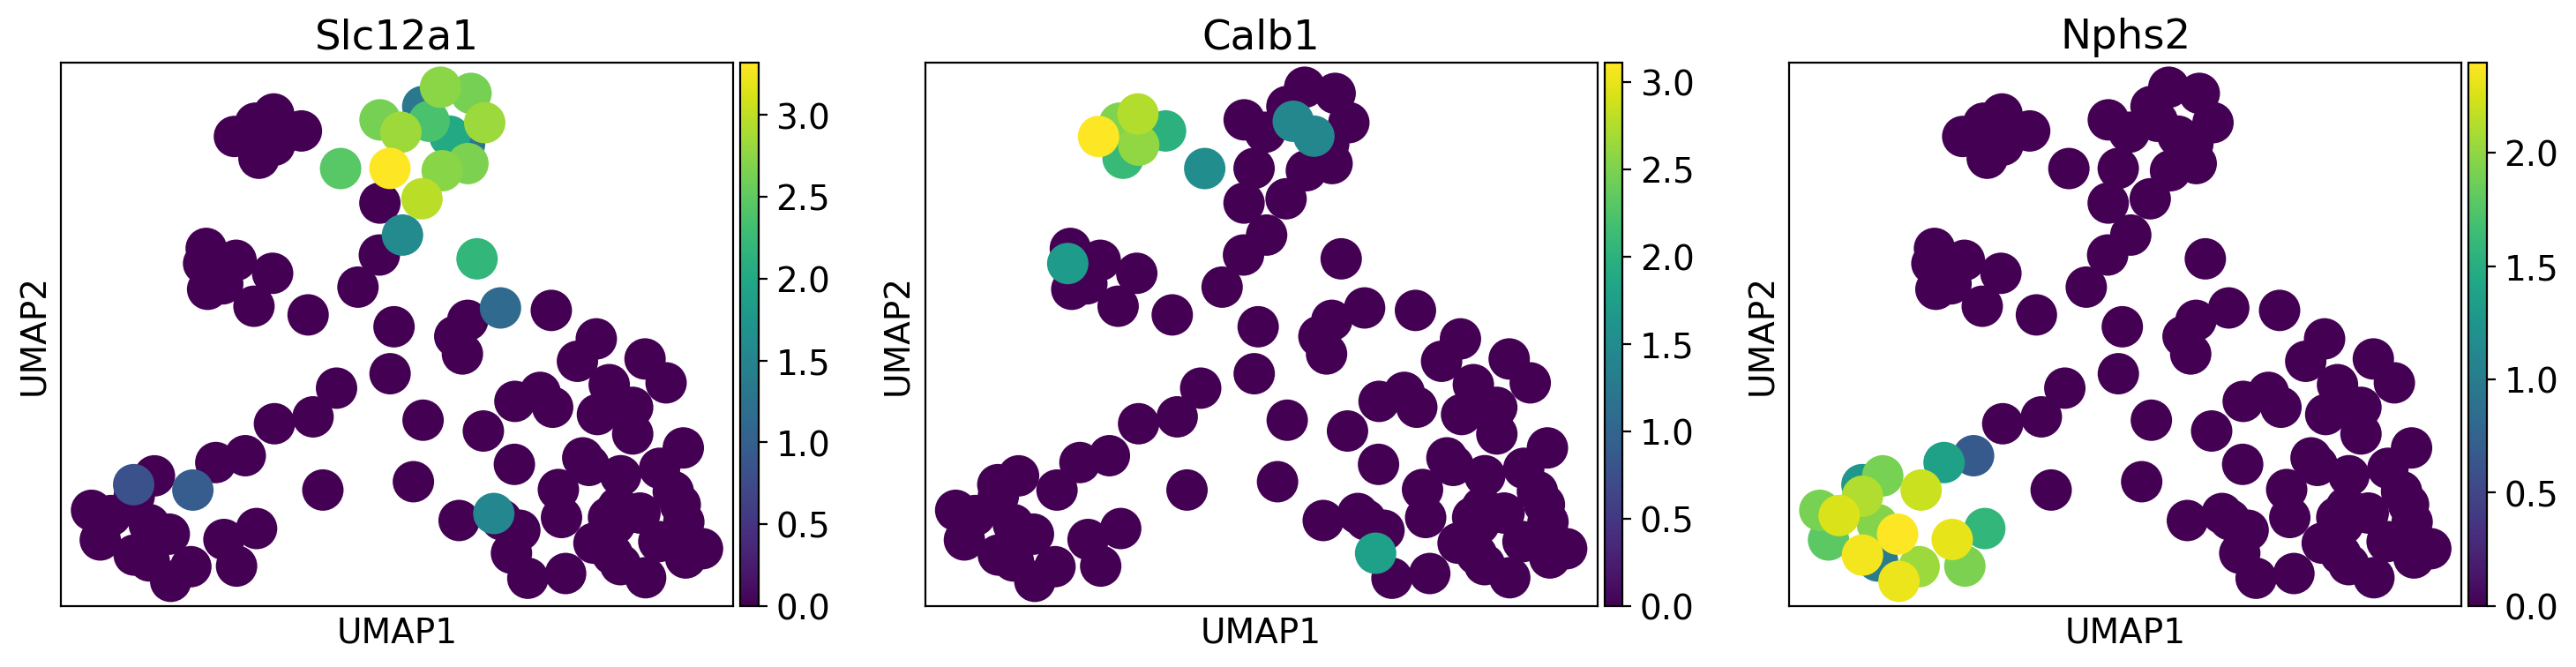

Cellpose


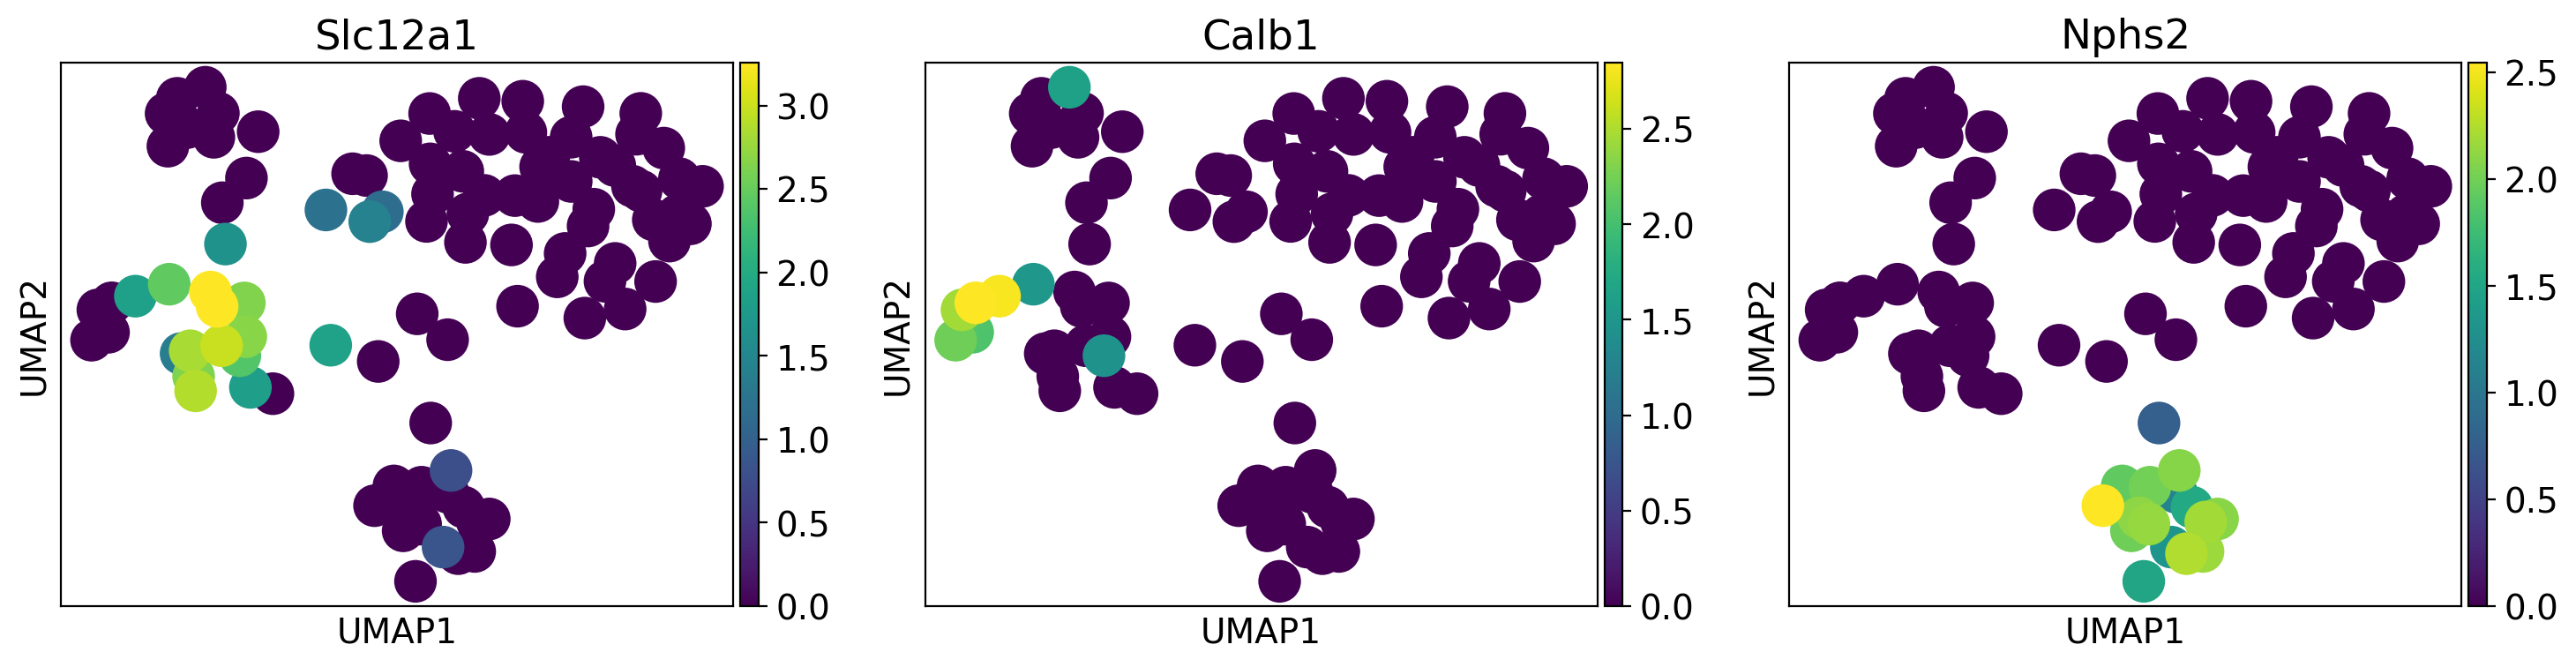

StarDist


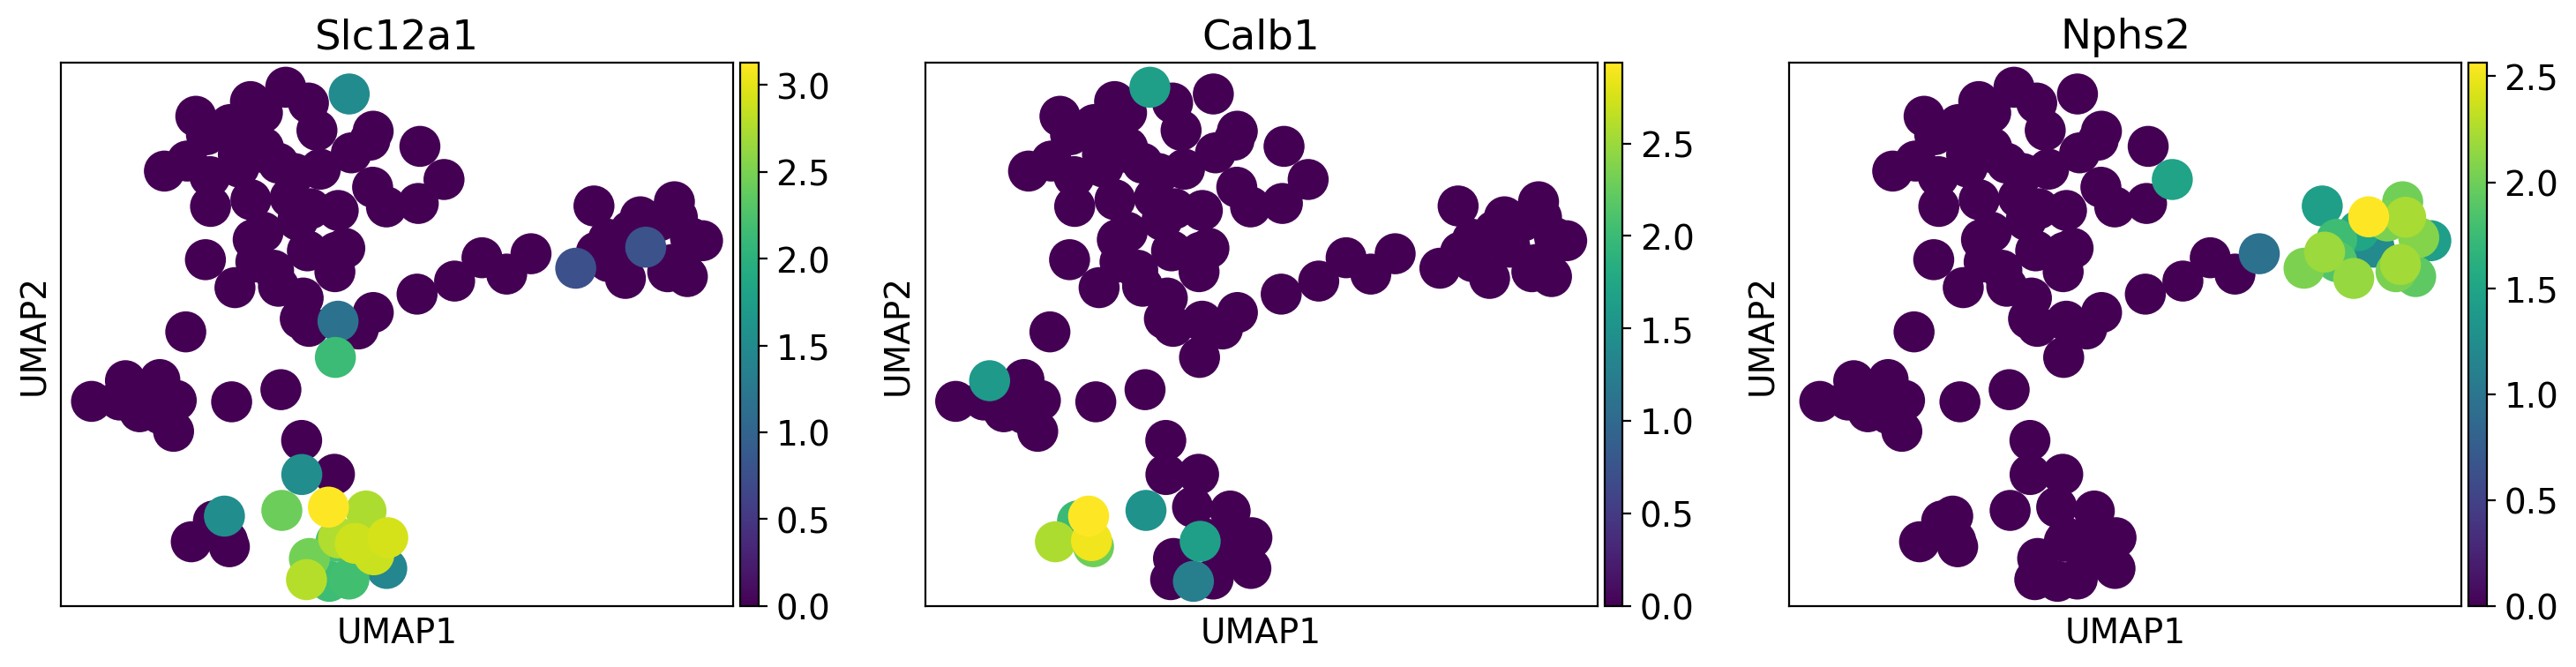

Deepcell


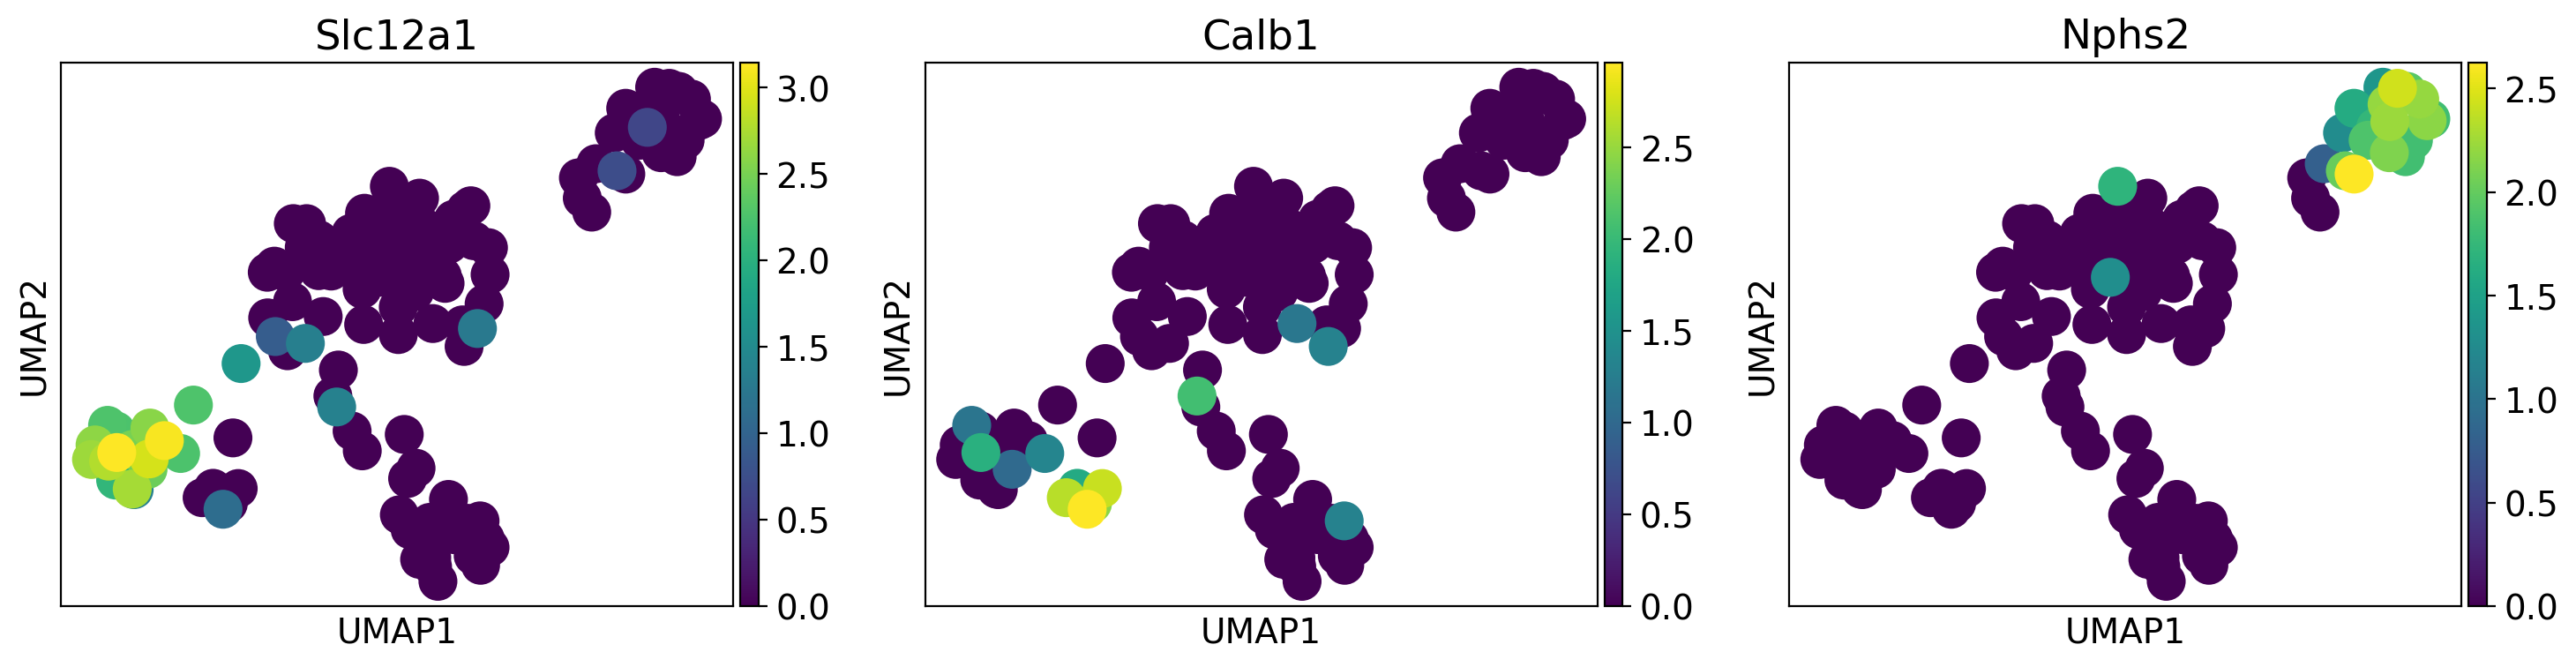

Baysor


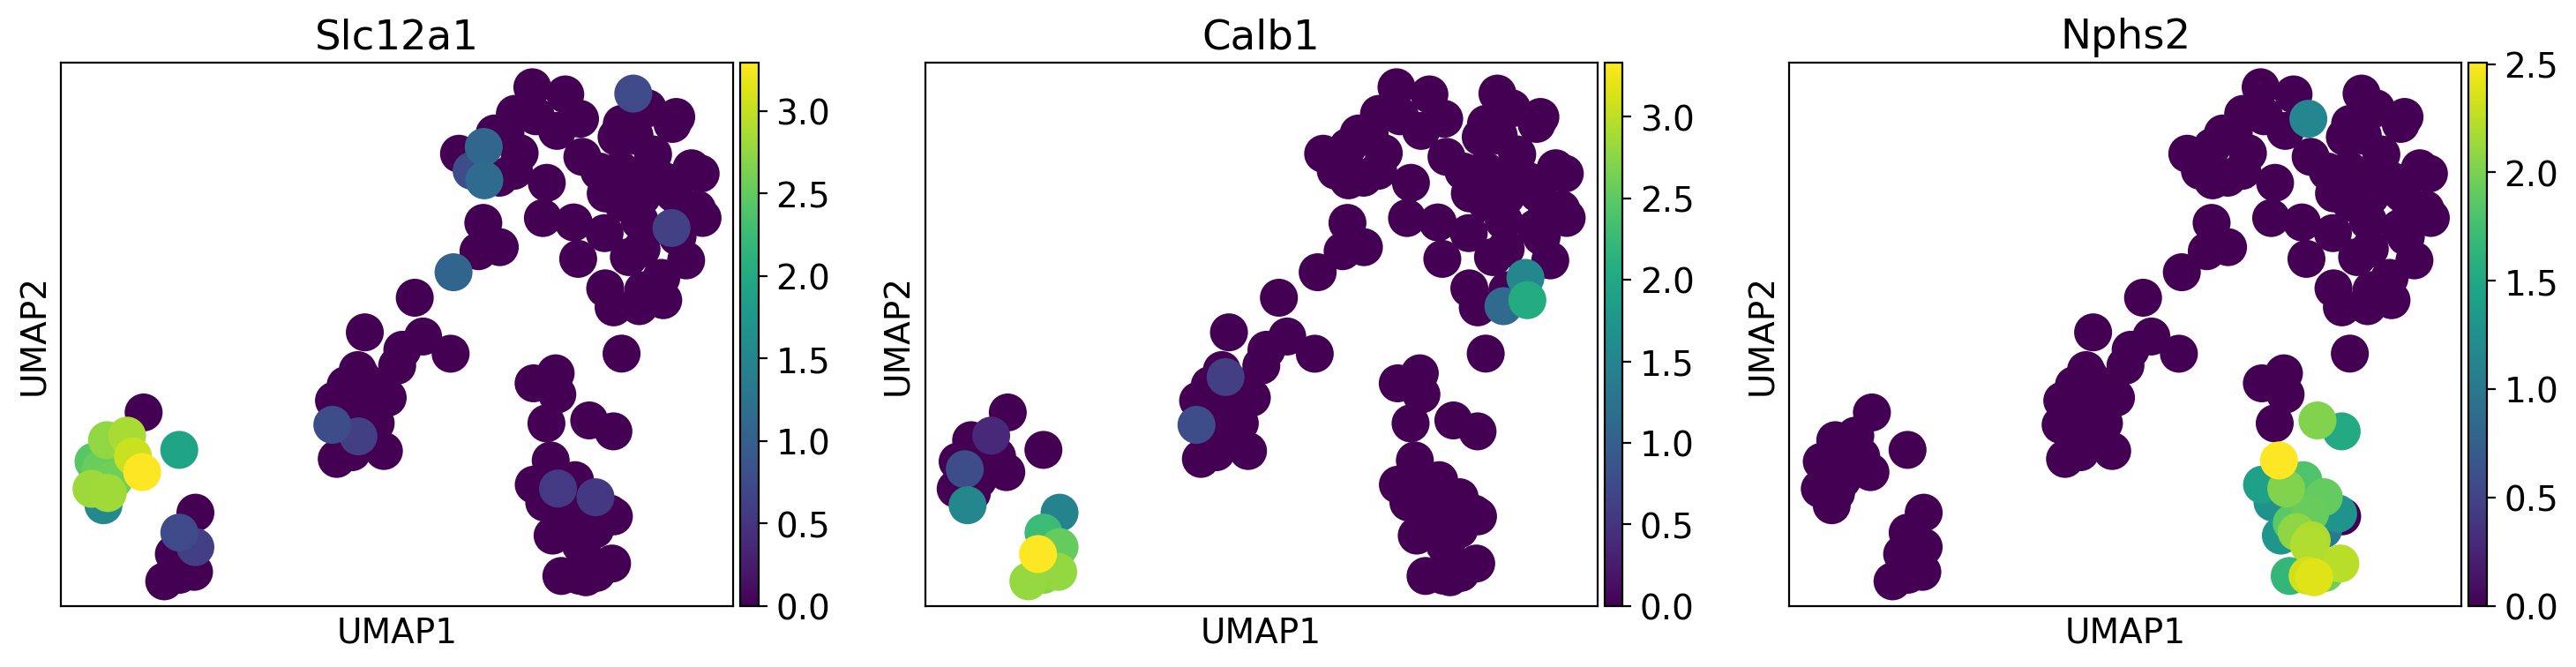

In [234]:
for i, method in enumerate(methods):
    print(method)
    with plt.rc_context({"figure.figsize":(5,4), "figure.dpi": (200), "font.size": 14}):
        sc.pl.umap(adata_dict[method], color=['Slc12a1','Calb1','Nphs2'], ncols=8, use_raw=False, save = f"_umap_{method}.png")

XeniumNuclei


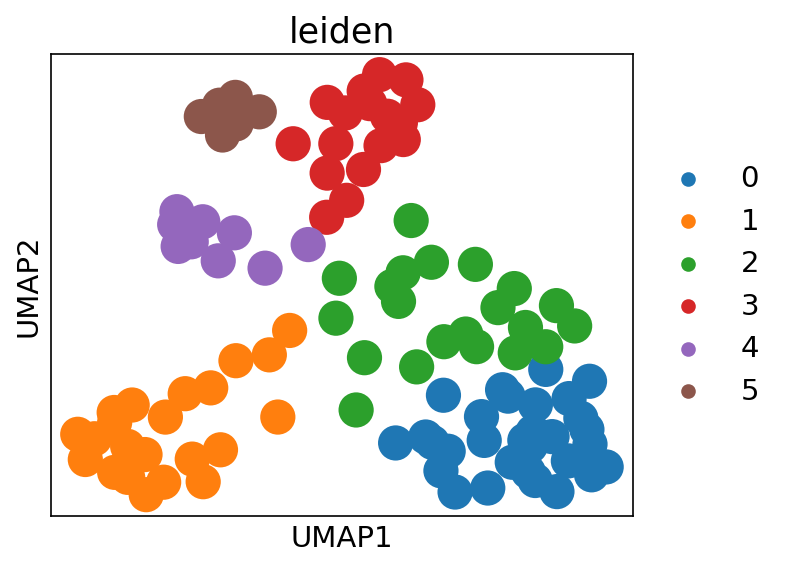

Cellpose


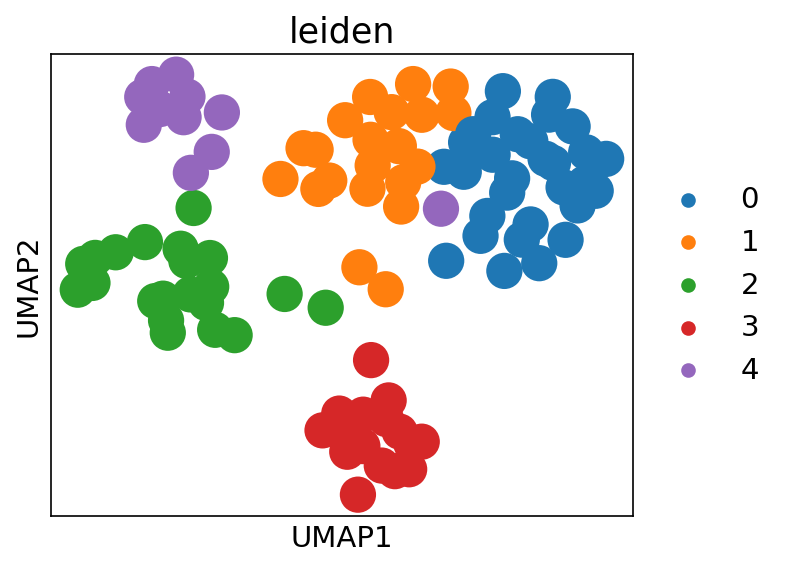

StarDist


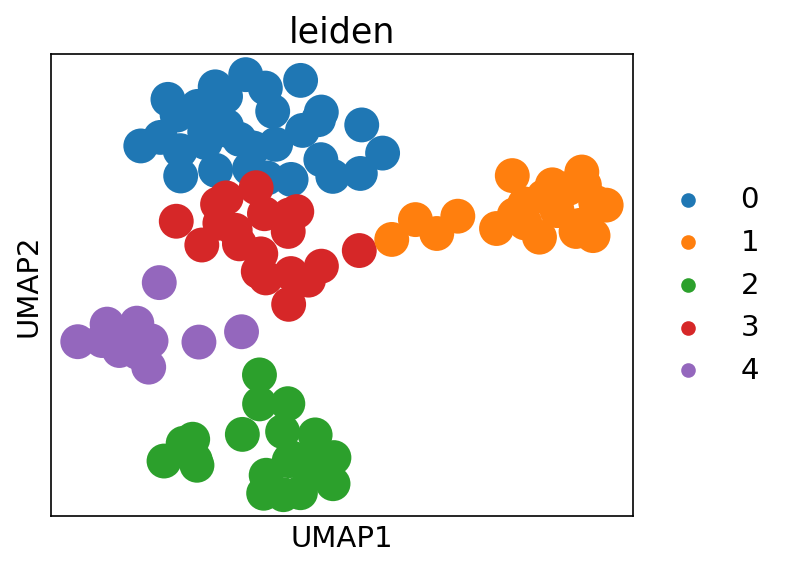

Deepcell


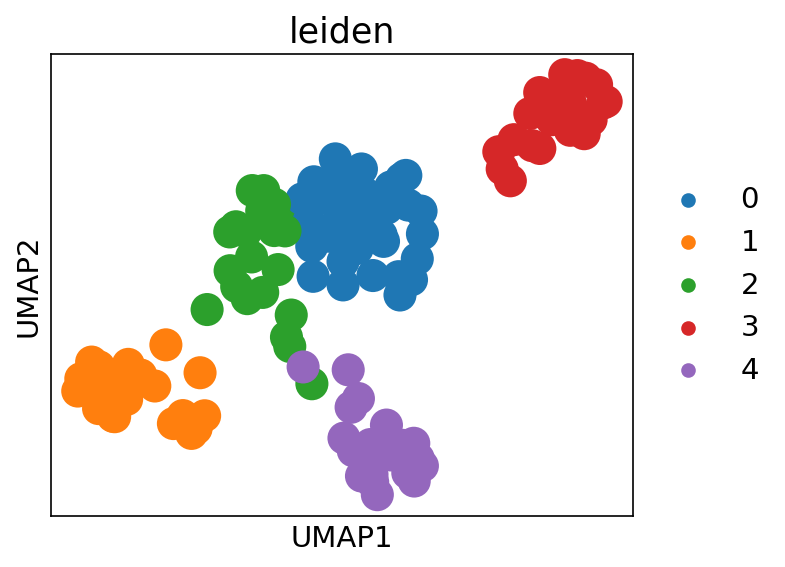

Baysor


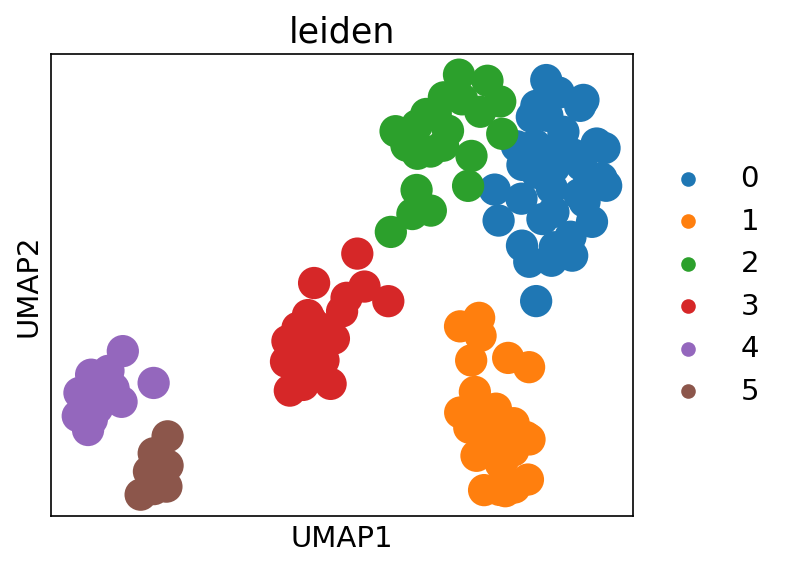

In [226]:
for i, method in enumerate(methods):
    print(method)
    with plt.rc_context({"figure.figsize":(5,4), "figure.dpi": (150), "font.size": 14,}):
        sc.pl.umap(adata_dict[method], color=['leiden'], ncols=8, use_raw=False, save = f"_umap_{method}_leiden.png")

In [197]:
for key, anndata_obj in adata_dict.items():
        anndata_obj.write(f'Seg_result/adata_{method}_processed.h5ad')

In [198]:
sc.tl.rank_genes_groups(adata_dict['Baysor'], 'leiden', method='wilcoxon', use_raw=False)

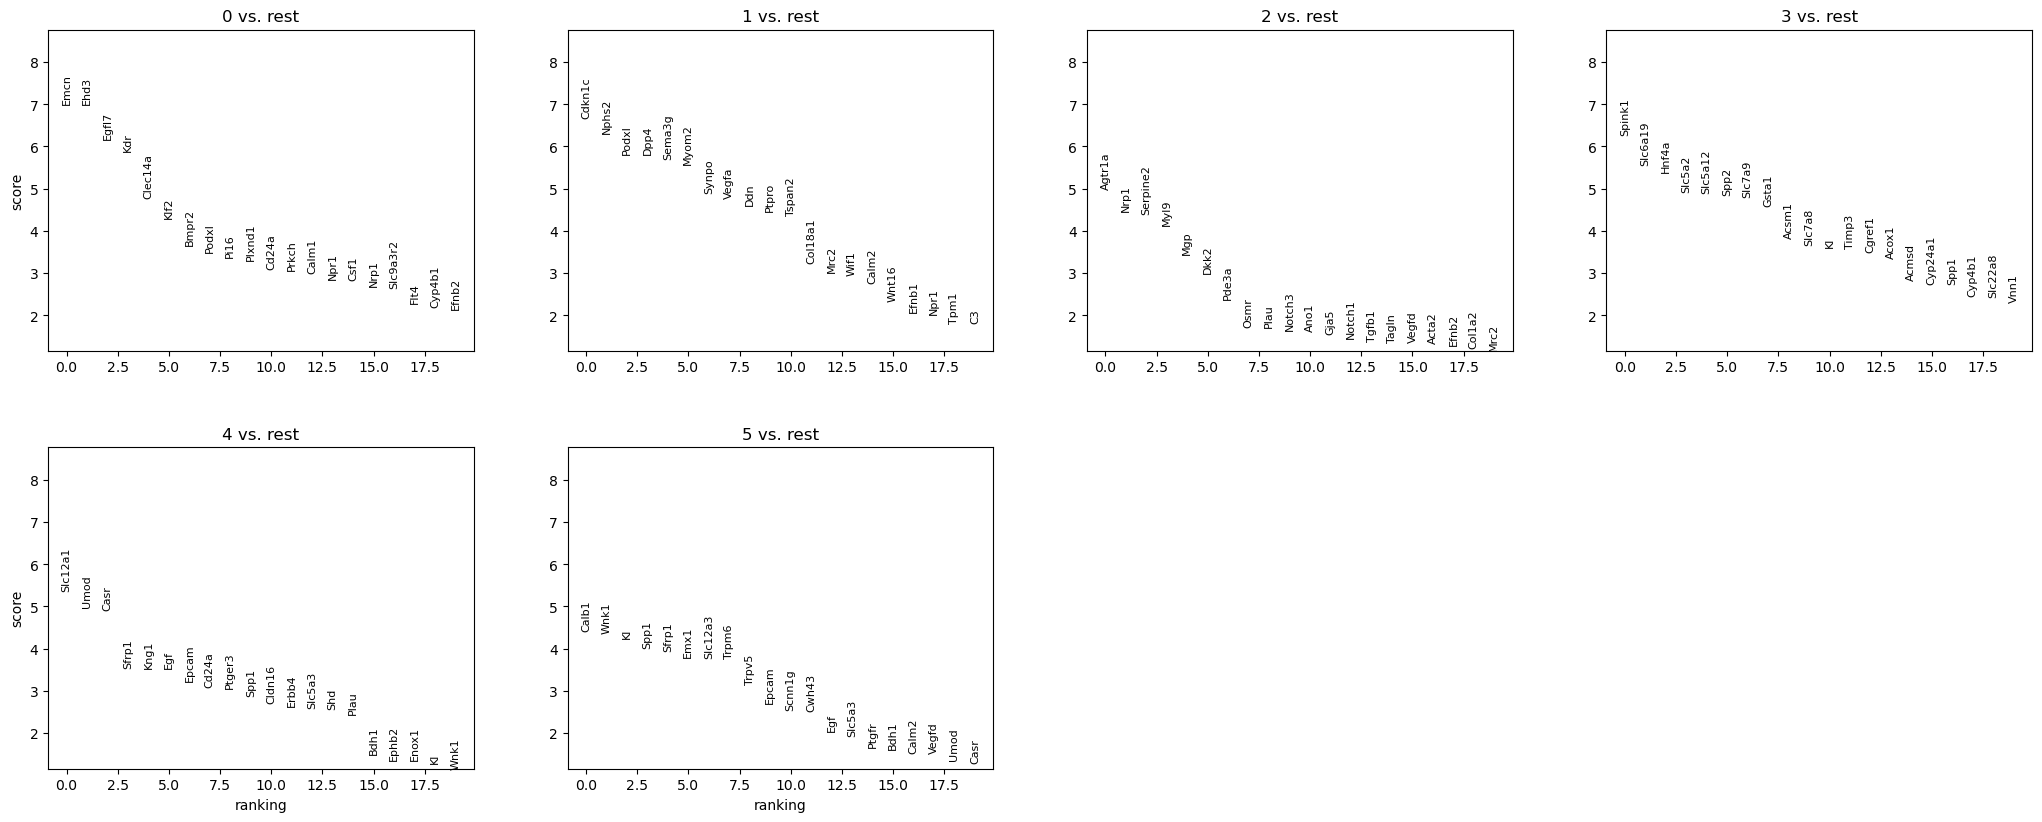

In [199]:
sc.pl.rank_genes_groups(adata_dict['Baysor'])